In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn import metrics

from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Global Path

In [2]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/'

# Data

In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

In [5]:
ec_color = df(index=gene_sets['NREC_profile'] + gene_sets['REC_profile'], columns=['colors'])
ec_color.loc[gene_sets['NREC_profile'], 'colors'] = 'crimson'
ec_color.loc[gene_sets['REC_profile'], 'colors'] = 'royalblue'

In [6]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [7]:
brca_sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/BRCA/brca_2020_tash_sig_info.csv',
                            header=0, index_col=0, sep=',')

In [8]:
brca_sig_info['cell_mfc_name'].value_counts()

MCF7        9686
MDAMB231    1433
SKBR3        410
HS578T       308
BT20         279
BT474          3
Name: cell_mfc_name, dtype: int64

In [9]:
sub_MCF7 = brca_sig_info[brca_sig_info['cell_mfc_name'] == 'MCF7'].index

In [10]:
# shRNA perturbations that targeting these genes should be able to inhibit the expression of sig_defc_91061_up
## read original lv5 signature matrix
brca_trt_sh_original = pd.read_csv(data_home + '/CMAP2020_Cancer/BRCA/CMAP2020_lv5_trt_sh_merged.csv',
                                   header=0, index_col=0, sep=',')
brca_trt_sh_original.index = brca_trt_sh_original.index.astype(int)
brca_trt_sh_original = brca_trt_sh_original[brca_trt_sh_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [11]:
shift_shRNA = pd.read_csv(poseidon_home + 'shift_ability/BRCA_trt_sh.csv', header=0, index_col=0, sep=',')

In [12]:
shift_shRNA = shift_shRNA[shift_shRNA.index.isin(sub_MCF7)]

# Shift ability of shRNAs

In [13]:
# experiments directly targeting NREC and REC
tar_dir_EC = shift_shRNA[shift_shRNA['cmap_name'].isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])].index

In [14]:
# KO eff available
ko_eff = brca_trt_sh_original[brca_trt_sh_original.index.isin(df(shift_shRNA.loc[tar_dir_EC, 'cmap_name'])['cmap_name'])].index

In [15]:
ko_eff_cal = df(index=tar_dir_EC, columns=['zexpr_lv5', 'gene'])
for exp in tar_dir_EC:
    ko_eff_cal.at[exp, 'zexpr_lv5'] = brca_trt_sh_original.loc[shift_shRNA.loc[exp, 'cmap_name'], exp]
    ko_eff_cal.at[exp, 'gene'] = shift_shRNA.loc[exp, 'cmap_name']

In [16]:
# select the experiments with KO efficiency greater than 1.5 (z-score, decrease at 1.5 std)
top_ko_eff = ko_eff_cal[ko_eff_cal['zexpr_lv5'] <= -1]
top_ko_eff.shape

(151, 2)

In [17]:
top_ko_eff['NREC_enr'] = shift_shRNA['NREC_profile']
top_ko_eff['REC_enr'] = shift_shRNA['REC_profile']
top_ko_eff['shift_ability'] = shift_shRNA['shift_ability']

<ipython-input-17-114ec2009237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ko_eff['NREC_enr'] = shift_shRNA['NREC_profile']
<ipython-input-17-114ec2009237>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ko_eff['REC_enr'] = shift_shRNA['REC_profile']
<ipython-input-17-114ec2009237>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [18]:
top_ko_eff_nrec = top_ko_eff[top_ko_eff['gene'].isin(gene_sets['NREC_profile'])]
top_ko_eff_nrec

,zexpr_lv5,gene,NREC_enr,REC_enr,shift_ability
KDB010_MCF7_144H:TRCN0000039640:-666,-1.62698,MYC,-0.340311,0.480882,0.821193
KDB008_MCF7_96H:TRCN0000029127:-666,-10,VDAC1,-0.383916,0.425496,0.809413
MUC.KD002_MCF7_96H:TRCN0000231944:-666,-1.34553,CRKL,-0.302860,0.503779,0.806639
KDA010_MCF7_144H:TRCN0000074562:-666,-1.7731,NONO,-0.356482,0.381494,0.737976
KDA002_MCF7_96H:TRCN0000029390:-666,-2.87081,ANXA5,-0.346273,0.384156,0.730430
...,...,...,...,...,...
KDB008_MCF7_96H:TRCN0000014824:-666,-1.59049,TBX2,0.185785,-0.324697,-0.510482
MUC.KD002_MCF7_96H:TRCN0000039961:-666,-3.60872,CDK2,0.199871,-0.317036,-0.516908
MUC.KD002_MCF7_96H:TRCN0000014825:-666,-1.12061,TBX2,0.179404,-0.337749,-0.517154
KDC006_MCF7_96H:TRCN0000000603:-666,-2.31293,CSNK1E,0.282384,-0.344492,-0.626876


In [19]:
top_ko_eff_rec = top_ko_eff[top_ko_eff['gene'].isin(gene_sets['REC_profile'])]
top_ko_eff_rec

,zexpr_lv5,gene,NREC_enr,REC_enr,shift_ability
KDC004_MCF7_96H:TRCN0000019096:-666,-1.20974,ARNTL,-0.266160,0.417017,0.683177
KDD004_MCF7_96H:TRCN0000021067:-666,-1.78836,ID2,-0.306703,0.350272,0.656975
KDD005_MCF7_96H:TRCN0000039757:-666,-3.77585,RPS6KA1,-0.294217,0.329543,0.623760
KDB008_MCF7_96H:TRCN0000062711:-666,-2.59813,BID,-0.321448,0.299362,0.620810
KDB004_MCF7_144H:TRCN0000021067:-666,-2.2761,ID2,-0.301556,0.291020,0.592576
KDB008_MCF7_96H:TRCN0000013696:-666,-1.39412,CEBPD,-0.339384,0.227419,0.566804
KDA007_MCF7_144H:TRCN0000021067:-666,-2.09391,ID2,-0.270003,0.258801,0.528803
KDA006_MCF7_144H:TRCN0000053212:-666,-4.11503,POLD4,-0.312639,0.184423,0.497061
KDB008_MCF7_96H:TRCN0000062712:-666,-1.70535,BID,-0.160750,0.262956,0.423706
KDB007_MCF7_144H:TRCN0000056593:-666,-1.32772,FDX1,-0.228627,0.165249,0.393876


In [20]:
top_ko_eff.loc[top_ko_eff_nrec.index, 'EC_profile'] = 'crimson'
top_ko_eff.loc[top_ko_eff_rec.index, 'EC_profile'] = 'royalblue'

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [21]:
top_ko_eff_merged = brca_trt_sh_original[list(top_ko_eff_nrec.index) + list(top_ko_eff_rec.index)]

In [22]:
top_ko_eff_merged_ec = top_ko_eff_merged[top_ko_eff_merged.index.isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])]

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


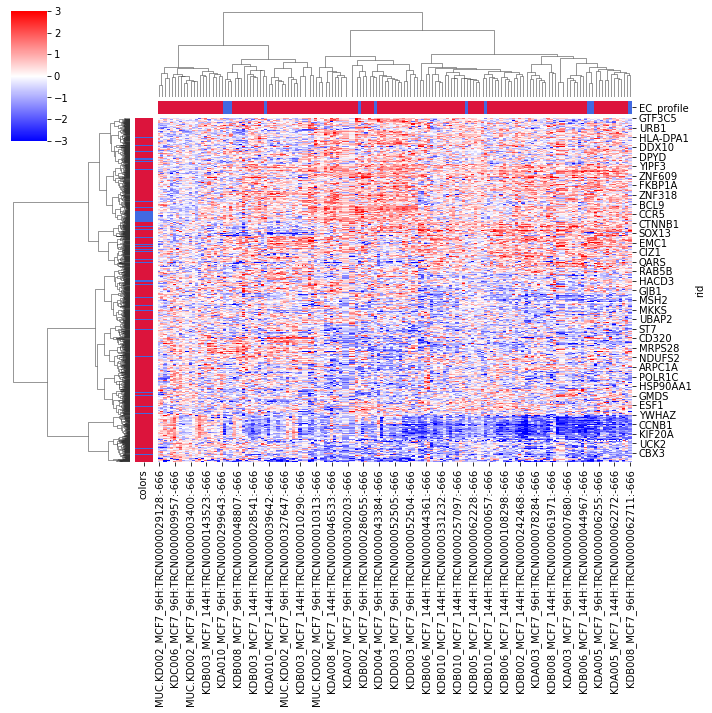

In [23]:
sns.clustermap(top_ko_eff_merged_ec,
               vmin=-3, vmax=3, cmap='bwr', method='ward',
               col_colors=top_ko_eff['EC_profile'],
               row_colors=ec_color['colors'])

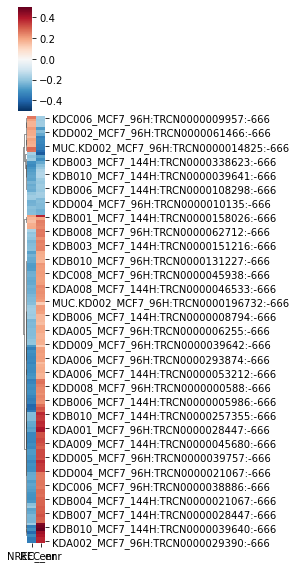

In [24]:
sns.clustermap(top_ko_eff[['NREC_enr', 'REC_enr']],
               figsize=(4, 8),
               row_cluster=True, col_cluster=False,
               cmap='RdBu_r', vmin=-.5, vmax=.5)

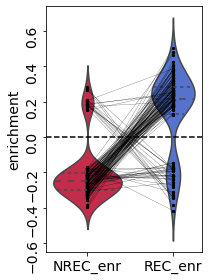

In [25]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
               inner='quartile',
               data=pd.melt(top_ko_eff.loc[top_ko_eff_nrec.index, ['NREC_enr', 'REC_enr']]),
               palette={'NREC_enr': 'crimson', 'REC_enr': 'royalblue'})

plt.scatter(np.zeros(len(top_ko_eff_nrec.index)), top_ko_eff.loc[top_ko_eff_nrec.index, 'NREC_enr'], s=5, c='k')
plt.scatter(np.ones(len(top_ko_eff_nrec.index)), top_ko_eff.loc[top_ko_eff_nrec.index, 'REC_enr'], s=5, c='k')
for i in top_ko_eff_nrec.index:
    plt.plot([0, 1], [top_ko_eff.loc[i, 'NREC_enr'], top_ko_eff.loc[i, 'REC_enr']], c='k', linewidth=0.2)

plt.axhline(y=0., c='k', ls='--')
plt.ylabel('enrichment', fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/direct_target_MCF7/NREC_targeted.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/direct_target_MCF7/NREC_targeted.pdf', transparent=True)

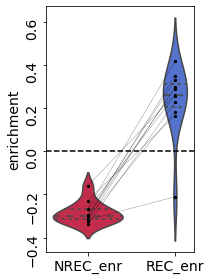

In [26]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
               inner='quartile',
               data=pd.melt(top_ko_eff.loc[top_ko_eff_rec.index, ['NREC_enr', 'REC_enr']]),
               palette={'NREC_enr': 'crimson', 'REC_enr': 'royalblue'})

plt.scatter(np.zeros(len(top_ko_eff_rec.index)), top_ko_eff.loc[top_ko_eff_rec.index, 'NREC_enr'], s=5, c='k')
plt.scatter(np.ones(len(top_ko_eff_rec.index)), top_ko_eff.loc[top_ko_eff_rec.index, 'REC_enr'], s=5, c='k')
for i in top_ko_eff_rec.index:
    plt.plot([0, 1], [top_ko_eff.loc[i, 'NREC_enr'], top_ko_eff.loc[i, 'REC_enr']], c='k', linewidth=0.2)

plt.axhline(y=0., c='k', ls='--')
plt.ylabel('enrichment', fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/direct_target_MCF7/REC_targeted.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/direct_target_MCF7/REC_targeted.pdf', transparent=True)# 

In [27]:
shift_shRNA_tar_dir = shift_shRNA[shift_shRNA.index.isin(tar_dir_EC)]

In [28]:
for g in shift_shRNA_tar_dir.index:
    shift_shRNA_tar_dir.at[g, 'EC_profile'] = ec_color.loc[shift_shRNA_tar_dir.loc[g, 'cmap_name'], 'colors']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [29]:
top_ko_shRNA_shift = shift_shRNA[shift_shRNA.index.isin(top_ko_eff.index)]

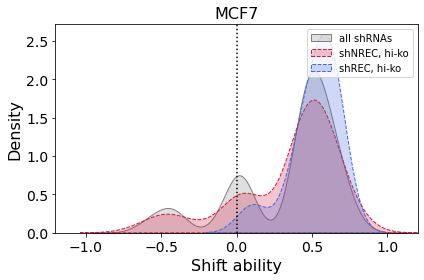

In [31]:
plt.figure(figsize=(6, 4))
sns.kdeplot(x='shift_ability', data=shift_shRNA,
            # cumulative=True,
            label='all shRNAs', fill=True, color='grey')
# sns.rugplot(x='modified', data=shRNA_shift, color='grey')
sns.kdeplot(x='shift_ability', data=shift_shRNA[shift_shRNA.index.isin(top_ko_eff_nrec.index)],
            # cumulative=True,
            label='shNREC, hi-ko', fill=True, color='crimson', ls='--')
# sns.rugplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_nrec.index)], color='crimson')
sns.kdeplot(x='shift_ability', data=shift_shRNA[shift_shRNA.index.isin(top_ko_eff_rec.index)],
            # cumulative=True,
            label='shREC, hi-ko', fill=True, color='royalblue', ls='--')
# sns.rugplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_rec.index)], color='royalblue')
plt.title('MCF7', fontsize=16)
plt.xlabel('Shift ability', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.axvline(x=0, ls=':', c='k')
plt.xlim(-1.2, 1.2)
plt.legend()
plt.yticks(rotation=0, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/shift_ability/MCF7.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/shift_ability/MCF7.pdf', transparent=True)